In [24]:
import tensorflow as tf
from tensorflow.keras import datasets, models, layers, utils, activations, losses, optimizers, metrics, Sequential
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd

In [25]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [26]:
# Define Parameters
num_classes = 3
IMG_SIZE = 224

#### Data Visualization

In [27]:
paths = glob('/gdrive/My Drive/AI_medical/Week3/retina-dataset/retina-train/*.jpeg')
paths_test = sorted(glob('/gdrive/My Drive/AI_medical/Week3/retina-dataset/retina-test/*.jpeg'))
len(paths), len(paths_test)

(2086, 522)

/gdrive/My Drive/AI_medical/Week3/retina-dataset/retina-train/30692_left_0.jpeg


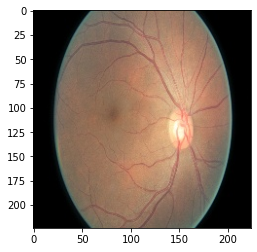

In [28]:
idx = 6
path = paths[idx]
img = cv2.imread(path)[:,:,::-1]
plt.imshow(img)
print(path)

In [29]:
all_filenames = [os.path.split(p)[1] for p in paths] # path -> ***.jpeg
print(all_filenames[:3])
all_cls = [int(name.split('.')[0].split('_')[-1]) for name in all_filenames] # ***.jpeg -> 0~4
print(all_cls[:3])

['30570_left_2.jpeg', '30586_left_0.jpeg', '30602_right_0.jpeg']
[2, 0, 0]


<BarContainer object of 3 artists>

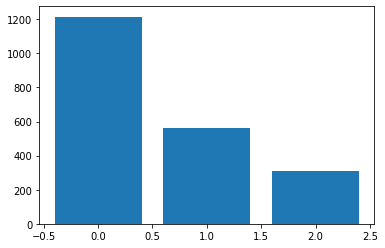

In [30]:
# Class distribution
cls, count = np.unique(all_cls, return_counts=True)
plt.bar(cls, count)

#### Prepare Data

In [31]:
# split dataset
path_train, path_val = train_test_split(paths, test_size=0.2)

len(path_train), len(path_val)

(1668, 418)

In [32]:
def create_dataset(paths, img_size=IMG_SIZE, num_classes=num_classes, test=False):
    num_data = len(paths)
    x_data = np.empty((num_data, img_size, img_size, 3))
    y_data = np.empty((num_data))

    for i, path in enumerate(tqdm(paths)):
        # read image and preprocess
        img = cv2.imread(path)[:,:,::-1]
        img = cv2.resize(img, (img_size, img_size))
        img = img / 255.
        x_data[i] = img

        if not test:
            # read class label
            filename = os.path.split(path)[1]
            cls = int(filename.split('.')[0].split('_')[-1]) # '38200_left_0.jpeg' -> 0
            y_data[i] = cls
    if not test:
        y_data = utils.to_categorical(y_data, num_classes=num_classes)
        return x_data, y_data
    else:
        return x_data

In [33]:
x_train, y_train = create_dataset(path_train)
x_val, y_val = create_dataset(path_val)
x_test = create_dataset(paths_test, test=True)

100%|██████████| 522/522 [00:01<00:00, 298.32it/s]


In [34]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1668, 224, 224, 3), (1668, 3), (418, 224, 224, 3), (418, 3))

#### Prepare model

In [35]:
# Build your own model
model = models.Sequential()
model.add(layers.Conv2D(filters=64,kernel_size=3,activation='relu',input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.Conv2D(filters=64,kernel_size=3,activation='relu',padding='same'))
model.add(layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(filters=128,kernel_size=3,activation='relu',padding='same'))
model.add(layers.Conv2D(filters=128,kernel_size=3,activation='relu',padding='same'))
model.add(layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(filters=256,kernel_size=3,activation='relu',padding='same'))
model.add(layers.Conv2D(filters=256,kernel_size=3,activation='relu',padding='same'))
model.add(layers.Conv2D(filters=256,kernel_size=3,activation='relu',padding='same'))
model.add(layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(filters=512,kernel_size=3,activation='relu',padding='same'))
model.add(layers.Conv2D(filters=512,kernel_size=3,activation='relu',padding='same'))
model.add(layers.Conv2D(filters=512,kernel_size=3,activation='relu',padding='same'))
model.add(layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(filters=512,kernel_size=3,activation='relu',padding='same'))
model.add(layers.Conv2D(filters=512,kernel_size=3,activation='relu',padding='same'))
model.add(layers.Conv2D(filters=512,kernel_size=3,activation='relu',padding='same'))
model.add(layers.MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())

model.add(layers.Dense(4096,activation='relu'))
model.add(layers.Dense(4096,activation='relu'))
model.add(layers.Dense(num_classes,activation='softmax'))

In [36]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 222, 222, 64)      1792      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 222, 222, 64)      36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 111, 111, 64)      0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 111, 111, 64)      0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 111, 111, 128)     73856     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 111, 111, 128)     147584    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 55, 55, 128)      

In [37]:
# optimizer=optimizers.SGD()
model.compile(optimizer='adam', 
              loss=losses.categorical_crossentropy, 
              metrics=[metrics.categorical_accuracy])

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    rotation_range = 20,
    horizontal_flip=True
)

datagen.fit(x_train)
logs = model.fit(datagen.flow(x_train,y_train,batch_size=64),epochs=20,validation_data = datagen.flow(x_val, y_val))

Epoch 1/20
27/27 [==============================] - 21s 752ms/step - loss: 4.3012 - categorical_accuracy: 0.4842 - val_loss: 1.0263 - val_categorical_accuracy: 0.5718
Epoch 2/20
27/27 [==============================] - 20s 726ms/step - loss: 0.9923 - categorical_accuracy: 0.5756 - val_loss: 0.9658 - val_categorical_accuracy: 0.5718
Epoch 3/20
27/27 [==============================] - 20s 741ms/step - loss: 0.9624 - categorical_accuracy: 0.5702 - val_loss: 0.9659 - val_categorical_accuracy: 0.5718
Epoch 4/20
27/27 [==============================] - 20s 730ms/step - loss: 0.9518 - categorical_accuracy: 0.5841 - val_loss: 0.9608 - val_categorical_accuracy: 0.5718
Epoch 5/20
27/27 [==============================] - 20s 729ms/step - loss: 0.9588 - categorical_accuracy: 0.5765 - val_loss: 0.9645 - val_categorical_accuracy: 0.5718
Epoch 6/20
27/27 [==============================] - 20s 729ms/step - loss: 0.9506 - categorical_accuracy: 0.5851 - val_loss: 0.9640 - val_categorical_accuracy: 0.571

#### Make Submission file

In [39]:
predictions = np.argmax(model.predict(x_test), axis=-1)

df = pd.DataFrame()
df['Id'] = [p.split(os.sep)[-1] for p in paths_test]
df['Category'] = predictions
df.to_csv('submission.csv', index=None)
df

,Id,Category
0,10017_left.jpeg,0
1,10031_right.jpeg,0
2,10150_left.jpeg,0
3,10154_right.jpeg,0
4,10440_right.jpeg,0
...,...,...
517,9608_left.jpeg,0
518,9673_right.jpeg,0
519,9690_left.jpeg,0
520,9717_right.jpeg,0


In [40]:
!cp submission.csv "/gdrive/My Drive/AI_medical/Week3/"